# Phishing Email Generation and Classification

Experimental notebook for classification and generation of phishing emails using several techniques.

Roadmap:
- Preprocessing
    - Sentiment Analysis
- Classification
    - Logistic Regression on emails
    - word2vec model
    - Transformer-based model
- Generation
    - With GANs
    - With T5
    - With transformers
- Adversarial Learning
    - EA-based method of classifying
    - Cyclical GANs
    - Use EA to seed an NN?

In [1]:
# Install requirements - uncomment this line the first time you run this notebook
#!pip install -r ./requirements.txt

In [2]:
import pandas as pd
import numpy as np
from functools import reduce
from tqdm import tqdm
# from .autonotebook import tqdm as notebook_tqdm
import itertools
from collections import Counter
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
myseed = 10897

# Email-Spam-Dataset

Use this dataset as preliminary exploration of classification techniques. Classifier can then be applied to Enron dataset if it works

0: not spam
1: spam

In [4]:
spam_col_names = ['id', 'Body', 'Label']

In [5]:
dfSA = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/completeSpamAssassin.csv', names=spam_col_names)

In [6]:
dfEnron = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/enronSpamSubset.csv', names=spam_col_names)

In [7]:
dfLing = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/lingSpam.csv', names=spam_col_names)

In [8]:
#merge datasets
dfs = [dfSA, dfEnron, dfLing]
dfSpam = pd.concat(dfs).dropna(axis=0)

Take a peek at the body of the emails

In [9]:
dfSpam.head()

,id,Body,Label
1.0,0.0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
2.0,1.0,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3.0,2.0,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
4.0,3.0,##############################################...,1
5.0,4.0,I thought you might like these:\n1) Slim Down ...,1


# Preprocessing

In avoidance of 'self-plagiarisation', much of the code for the `Dataset` class is adapted from my Text Processing Sentiment Analysis assignment. Code can be provided to markers on request

In [10]:
#nltk
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as NLTK_STOP
import string

In [11]:
#download wordnet for lemmatization
#uncomment appropriate line if you get error: "Resource wordnet not found.", "Resource punkt not found.", etc...

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [12]:
#spacy imports
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOP

#download spacy dataset
#uncomment the line below if you get error "Can't find model 'en_core_web_sm'"
# ! python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

C:\Users\theco\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


`Dataset` Class - this takes a `Dataframe` and applies various preprocessing/feature selection techniques to it

In [13]:
class Dataset:
    def __init__(self, df, preprocessing=["lower"], feature_selection=["alltokens"], retList=False):
        
        #read preprocessing and feature_selection configuration
        self.preprocessing = preprocessing
        self.feature_selection = feature_selection
        self.data = df
        self.retList = retList

        # === define various processors and regexes for various preprocessing/feature selection methods ===

        # NLTK Stemming Engine
        self.porter = PorterStemmer()

        #NLTK Lemmatizing Engine
        self.wn_lt = WordNetLemmatizer()

        #tokenizers

        #words regex - splits on word boundaries, doesn't include punctuation etc
        self.word_tokenizer = RegexpTokenizer(r'\w+')

        #create tokenizer based on NLTK-provided regex from Labs
        nltk_pat = r'''(?x) # set flag to allow verbose regexps
            (?:[A-Z]\.)+ # abbreviations, e.g. U.S.A.
            | \w+(?:-\w+)* # words with optional internal hyphens
            | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
            | \.\.\. # ellipsis
            | [][.,;"'?():_`-]
            | [>]?[:;][\']?[\(\)\[\]]+ # these are separate tokens; includes ], [
            '''
        self.nltk_tokenizer = RegexpTokenizer(nltk_pat)

        #create tokenizer based on custom regex based on above, with less features
        custom_pat = r'''(?x)
                \w+(?:-\w+)*
                |\$?\d+(?:\.\d+)?%?
                |\.\.\.'''
        self.custom_tokenizer = RegexpTokenizer(custom_pat)

        # stop words - SPACY_STOP defined above in imports

        self.NLTK_ENGLISH_STOP = set(NLTK_STOP.words('english'))

        # === apply preprocessing and feature selection ===

        self.process_phrases()
    
    def preprocess_phrase(self, phrase):
        """define preprocessing function for phrases
        can call any number of these options - however, some may not combine well"""

        if self.preprocessing == []:
            #no preprocessing
            return phrase
        if "lower" in self.preprocessing:
            #lowercase
            phrase = phrase.lower()
        if "newlines" in self.preprocessing:
            phrase = " ".join(filter(None, phrase.split("\n")))
        if "punc" in self.preprocessing:
            #remove punctuation
            phrase = phrase.translate(str.maketrans('','',string.punctuation))
        if "stemming" in self.preprocessing:
            #use NLTK stemming
            phrase = self.porter.stem(phrase)
        if "nltk_lemmatize" in self.preprocessing:
            #use NLTK's lemmatization method
            new_phrase = ""
            words = nltk.word_tokenize(phrase)
            for word in words:
                new_phrase += self.wn_lt.lemmatize(word)
            phrase = new_phrase
        if "spacy_lemmatize" in self.preprocessing:
            #use spacy's lemmatization method
            nlp_phrase = nlp(phrase)
            new_phrase = ""
            for token in nlp_phrase:
                new_phrase += (token.lemma_ + " ")
            phrase = new_phrase

        return phrase

    def extract_features_from_phrase(self, phrase):
        """define feature extraction function for phrases
        extracts all words from all phrases as features for document set
        for each method, if one has already been applied the phrase must be treated as a list"""

        #list of negation words from 
        negation_words = ["neither", "never", "no", "nobody", "none", "noone", "nor", "not", "nothing", "nowhere"]

        intensifer_words = ["absolutely", "completely", "extremely", "highly", "rather", "really", "so", "too", "totally", "utterly", "very"]

        #use if len(self.feature_selection) > 1 to check if any preprocessing already occurred, as input will be in a list

        if self.feature_selection == []:
            #we have to do some feature selection, absolute minimum is alltokens
            return phrase.split(" ")
        if "alltokens" in self.feature_selection:
            #split based on whitespace
            phrase = phrase.split(" ")
        if "nltk_tokenize" in self.feature_selection:
            #tokenize using NLTK tokenizer, with words regex
            if isinstance(phrase, list):
                phrase =  list(itertools.chain.from_iterable([self.word_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.word_tokenizer.tokenize(phrase)
                # print(phrase)
        if "nltk_tokenize_2" in self.feature_selection:
            #tokenize using NLTK's regex
            if isinstance(phrase, list):
                phrase =  list(itertools.chain.from_iterable([self.nltk_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.nltk_tokenizer.tokenize(phrase)
        if "custom_tokenize" in self.feature_selection:
            #tokenize with custom regex
            if isinstance(phrase, list):
                phrase = list(itertools.chain.from_iterable([self.custom_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.custom_tokenizer.tokenize(phrase)
        if "nltk_stoplist" in self.feature_selection:
            #use an NLTK stoplist
            if isinstance(phrase, list):#check words if already split into list
                #TODO: quicker way to run this?
                phrases = []
                for partial_phrase in phrase:
                    if partial_phrase not in self.NLTK_ENGLISH_STOP:
                        phrases.append(partial_phrase)
                phrase = phrases
            else:#split into list then eval words
                phrase = [word for word in phrase.split(" ") if word not in self.NLTK_ENGLISH_STOP]
        if "spacy_stoplist" in self.feature_selection:
            #use a spacy stoplist
            if isinstance(phrase, list):
                phrases = []
                for partial_phrase in phrase:
                    phrases +=  [word for word in partial_phrase.split(" ") if word not in list(SPACY_STOP)]
                phrase = list(itertools.chain.from_iterable(phrases))
            else:
                phrase = [word for word in phrase.split(" ") if word not in list(SPACY_STOP)]
        if "nltk_pos_tag" in self.feature_selection:
            #use POS tagging - must be a list, so split by spaces if not already
            if isinstance(phrase, list):
                phrase = nltk.pos_tag(phrase)
            else:
                phrase = phrase.split(" ")
                phrase = nltk.pos_tag(phrase)
        if "negation_bigrams" in self.feature_selection:
            #create bigrams with negation words + their successors
            if len(self.feature_selection) > 1:
                phrases = []
                for j in range(0, len(phrase)):
                    partial_phrase = phrase[j]
                    split = partial_phrase.split(" ")

                    for i in range(0, len(split)):
                        if split[i] in negation_words and i != len(split) - 1:
                            #add the negation word and its successor to the list of phrases
                            phrases.append(split[i] + " " + split[i+1])
                        else:
                            #skip to next partial if negation is at end of partial phrase
                            if split[i] in negation_words and j != len(phrase) - 1:
                                # print("Next partial")
                                phrases.append(split[i] + " " + phrase[j+1].split(" ")[0])
                            else:
                                #skip entirely if this is the last partial phrase
                                phrases.append(split[i])
                phrase = phrases
            else:
                split = phrase.split(" ")
                phrase = []
                for i in range(0, len(split)):
                    if split[i] in negation_words and i != len(split) - 1:
                        phrase.append(split[i] + " " + split[i+1])
                    else:
                        phrase.append(split[i])
        if "intensifier_bigrams" in self.feature_selection:
            #create bigrams with intensifier words + their successors
            if len(self.feature_selection) > 1:
                phrases = []
                for j in range(0, len(phrase)):
                    partial_phrase = phrase[j]
                    split = partial_phrase.split(" ")

                    for i in range(0, len(split)):
                        if split[i] in intensifer_words and i != len(split) - 1:
                            #add the intensifier word and its successor to the list of phrases
                            phrases.append(split[i] + " " + split[i+1])
                        else:
                            #skip to next partial if intensifier is at end of partial phrase
                            if split[i] in intensifer_words and  j != len(phrase) - 1:
                                phrases.append(split[i] + phrase[j+1].split(" ")[0])
                            else:
                                #skip entirely if this is the last partial phrase
                                phrases.append(split[i])
                phrase = phrases
            else:
                split = phrase.split(" ")
                phrase = []
                for i in range(0, len(split)):
                    if split[i] in intensifer_words and i != len(split) - 1:
                        phrase.append(split[i] + " " + split[i+1])
                    else:
                        phrase.append(split[i])

        if self.retList:
            return phrase
        else:#rejoin into one text body in case want to do different tokenisation/one-hot later on
            return " ".join(filter(None, phrase))

    def process_phrases(self):
        """extract bodies"""

        self.bodies = self.data['Body']
        
        #apply preprocessing function to all phrases using list comprehension
        self.preprocessed_phrases = [self.preprocess_phrase(phrase) for phrase in self.data['Body']]
        self.features = [self.extract_features_from_phrase(phrase) for phrase in self.preprocessed_phrases]

        data = {'id': self.data['id'], 'ppBody': self.features, 'label': self.data['Label']}
        self.pp_df = pd.DataFrame(data=data)

Instantiate our dataset `d` with basic feature selection + tokenisation

In [14]:
#instantiate a new dataset
#run the preprocessing with lowercasing, removing newlines, stemming, and tokenisation using the nltk regex
d = Dataset(dfSpam, preprocessing=["lower","newlines","stemming"], feature_selection=["nltk_tokenize"], retList=False)

In [15]:
a = "split me"
a.split(" ")

['split', 'me']

In [16]:
def split_doc_and_count(doc, delim=' '):
    """this splits a document (split by spaces by default)
    then runs Counter on the result"""
    return Counter(doc.split(delim))

In [17]:
def process_dataset(dataset):
    """applies post-processing to the dataframe rows"""

    #load the text body
    df = dataset.pp_df

    #find the negative and positive classes
    positive = df[df['label'] == "1"]
    negative = df[df['label'] == "0"]

    l_positive = len(positive)
    l_negative = len(negative)

    #which class is bigger?
    min_len = min(l_positive, l_negative)

    #take a random sample of the smaller class to remove class imbalance
    if l_positive > l_negative:
        positive = positive.sample(min_len, random_state=myseed)
    elif l_negative > l_positive:
        negative = negative.sample(min_len, random_state=myseed)

    #create counters from the text bodies
    dataset.pos_word_counter = positive['ppBody'].apply(split_doc_and_count).sum()
    dataset.neg_word_counter = negative['ppBody'].apply(split_doc_and_count).sum()

In [18]:
#uncomment the below if you are not loading the counts from a pickle file
# process_dataset(d)

In [19]:
d2 = Dataset(dfSpam, preprocessing=["lower","newlines","stemming"], feature_selection=["nltk_tokenize", "nltk_stoplist"], retList=False)

In [20]:
#uncomment the below if you are not loading the counts from a pickle file
# process_dataset(d2)

In [21]:
def save_pickle(object, path):
    if not os.path.exists('./Pickle'):
        os.makedirs('./Pickle')

    with open('./Pickle/' + path, 'wb') as output:
        pickle.dump(object, output)

In [22]:
def load_pickle(path):
    with open('./Pickle/' + path, 'rb') as input:
        return pickle.load(input)

Uncomment the below to save your counters to a file for later use

In [23]:
# save_pickle(d.pos_word_counter, 'd-pos.pickle')
# save_pickle(d.neg_word_counter, 'd-neg.pickle')
# save_pickle(d2.pos_word_counter, 'd-pos.pickle')
# save_pickle(d2.neg_word_counter, 'd-neg.pickle')

Uncomment the below to load your saved counters

In [24]:
d1_pos_counts = load_pickle('d-pos.pickle')
d1_neg_counts = load_pickle('d-neg.pickle')
d2_pos_counts = load_pickle('d2-pos.pickle')
d2_neg_counts = load_pickle('d2-neg.pickle')

# Exploratory Data Analysis

Run some tests on the datasets from `Email-Spam-Dataset`:
- find most common words in spam/not spam emails - plot on histogram
- classify the sentiment of each email as positive/negative and see if there's a pattern in spam/not spam

## Common Words

Pure count-based word analysis - better measure of informativeness can be achieved using TFIDF, but this also helps us identify what "useless" tokens we may have failed to remove

In [25]:
def print_most_common_n(counter, n, name):
    print(f"{n} most common tokens in {name}:\n")

    most_common = counter.most_common(n)

    if n < 6:
        output = ", ".join([f"\"{word}\" ({count})" for (word, count) in most_common])
    else:
        output = "\n".join([f"{word} ({count})" for (word, count) in most_common])

    print(output)

In [26]:
print_most_common_n(d1_pos_counts, 5, "dfSpam (with stopwords) - Spam emails")

5 most common tokens in dfSpam (with stopwords) - Spam emails:

"the" (57403), "_" (52195), "to" (46435), "and" (38993), "of" (34897)


In [27]:
print_most_common_n(d2_neg_counts, 20, "dfSpam (stopwords removed) - non-Spam emails")

20 most common tokens in dfSpam (stopwords removed) - non-Spam emails:

_ (174714)
language (15162)
university (15135)
subject (14113)
1 (13936)
http (12953)
enron (12349)
com (11705)
e (11580)
2 (10140)
one (9584)
0 (9432)
00 (9220)
information (9021)
mail (8764)
www (8569)
would (8195)
10 (8140)
new (8067)
please (8060)


In [28]:
def plot_hist(counter, n, name):
    words, counts = list(zip(*counter.most_common(n)))
    plt.hist(counts, words)

ConversionError: Failed to convert value(s) to axis units: ('_', 'language', 'university', 'subject', '1', 'http', 'enron', 'com', 'e', '2')

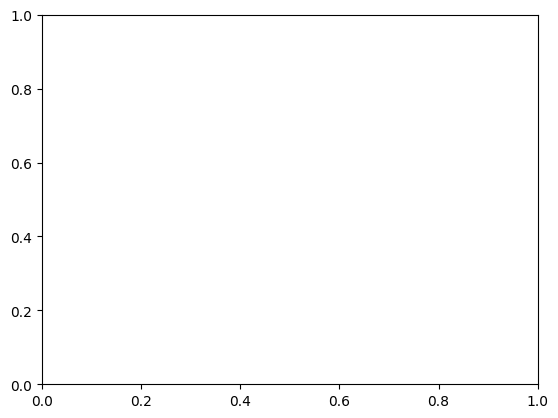

In [29]:
plot_hist(d2_neg_counts, 10, "dfSpam (stopwords removed) - non-Spam emails")

## Sentiment Analysis

# Email Classification

## TFIDF

Work in Progress: running TFIDF to classify Email-Spam-Dataset

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', max_features=10000)
features = tfidf.fit_transform(df.ppBody).toarray()

NameError: name 'df' is not defined

In [ ]:
features.shape

(18651, 10000)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

In [ ]:
X = d.pp_df.iloc[:, 0:2]
y = d.pp_df.iloc[:, 2]

ss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=10)
indexes = list(ss.split(X, y))
train_set  = indexes[0][0]
test_set  = indexes[0][1]
Xtrain = X.iloc[train_set, :]
ytrain = y.iloc[train_set]
Xtest = X.iloc[test_set, :]
ytest = y.iloc[test_set]

## Word2Vec

Classify with word2vec (see https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)

## BERT

Classify with BERT (also using TDS article methods)

## Random Forest

Use RF/ensemble method for some of the classifiers above to see which features work best and which preprocessing methods are good - exploring Phishing-Dataset-for-Machine-Learning features first may be helpful

# Phishing-Dataset-for-Machine-Learning

Inspect this dataset - it is for webpages (https://www.sciencedirect.com/science/article/pii/S0020025519300763?via%3Dihub) but some of the features may be applicable to email classification

Other repos that use this dataset to take inspiration from:
- https://github.com/andpalmier/MLWithPhishing
- https://github.com/rewanthtammana/Detect-phishing-websites-using-ML
- https://www.kaggle.com/code/fadilparves/pishing-detection-using-machine-learning

Random forests used to discover best features - we could apply similar to the Email-Spam-Dataset

## New Feature Extraction

Can we apply the features used in this dataset to Email-Spam-Dataset?

# Comments



# Todo

- [x] Remove NaN id from merged `dfSpam`
- [ ] Tokenise body data
- [ ] Set seed method
- [ ] Stratified Sample?